In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import xgcm
from xgcm.autogenerate import generate_grid_ds
import cartopy.crs as ccrs
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.plot import *
from dask import compute, delayed

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(12)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.148.0.248:35470' processes=7 threads=7, memory=119.98 GB>

_________
# 1. Read dataset


In [17]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'

# read rechunked data
grid = xr.open_zarr(out_dir_zarr+'grid.zarr')
ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl.zarr').isel(time=slice(0,100))
ds_TAUX = xr.open_zarr(out_dir_zarr+'oceTAUX.zarr').isel(time=slice(0,100))
ds_TAUY = xr.open_zarr(out_dir_zarr+'oceTAUY.zarr').isel(time=slice(0,100))

# data merge
ds = xr.merge([ds_KPP,ds_TAUX,ds_TAUY,grid])
print(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 100)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(100,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2011-11-27T11:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (fac

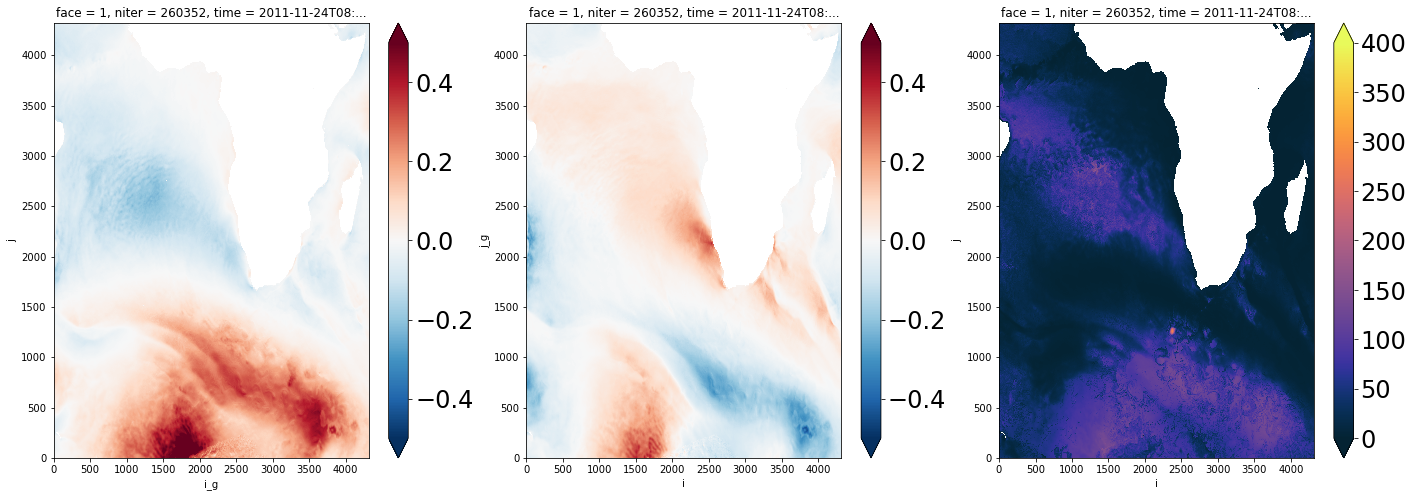

In [29]:

fig, ax = plt.subplots(figsize=(24,8))

ax = plt.subplot(131)
cax = (ds.oceTAUX.isel(face=1).sel(time='2011-11-24T08:00:00')).plot(x='i_g', y='j', cmap = 'RdBu_r', vmin=-0.5, vmax=0.5, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('', fontsize=24)

ax = plt.subplot(132)
cax = (ds.oceTAUY.isel(face=1).sel(time='2011-11-24T08:00:00')).plot(x='i', y='j_g', cmap = 'RdBu_r', vmin=-0.5, vmax=0.5, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('', fontsize=24)

ax = plt.subplot(133)
cax = (ds.KPPhbl.isel(face=1).sel(time='2011-11-24T08:00:00')).plot(x='i', y='j', cmap = cm.thermal, vmin=0, vmax=400, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('', fontsize=24)

In [18]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

In [19]:
oceTAUX_1 =  ds.oceTAUX.rename({'i_g': 'i'}).sel(time='2011-11-24T08:00:00')*ds.CS - ds.oceTAUY.rename({'j_g': 'j'}).sel(time='2011-11-24T08:00:00')*ds.SN
oceTAUY_1 =  ds.oceTAUX.rename({'i_g': 'i'}).sel(time='2011-11-24T08:00:00')*ds.SN + ds.oceTAUY.rename({'j_g': 'j'}).sel(time='2011-11-24T08:00:00')*ds.CS

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

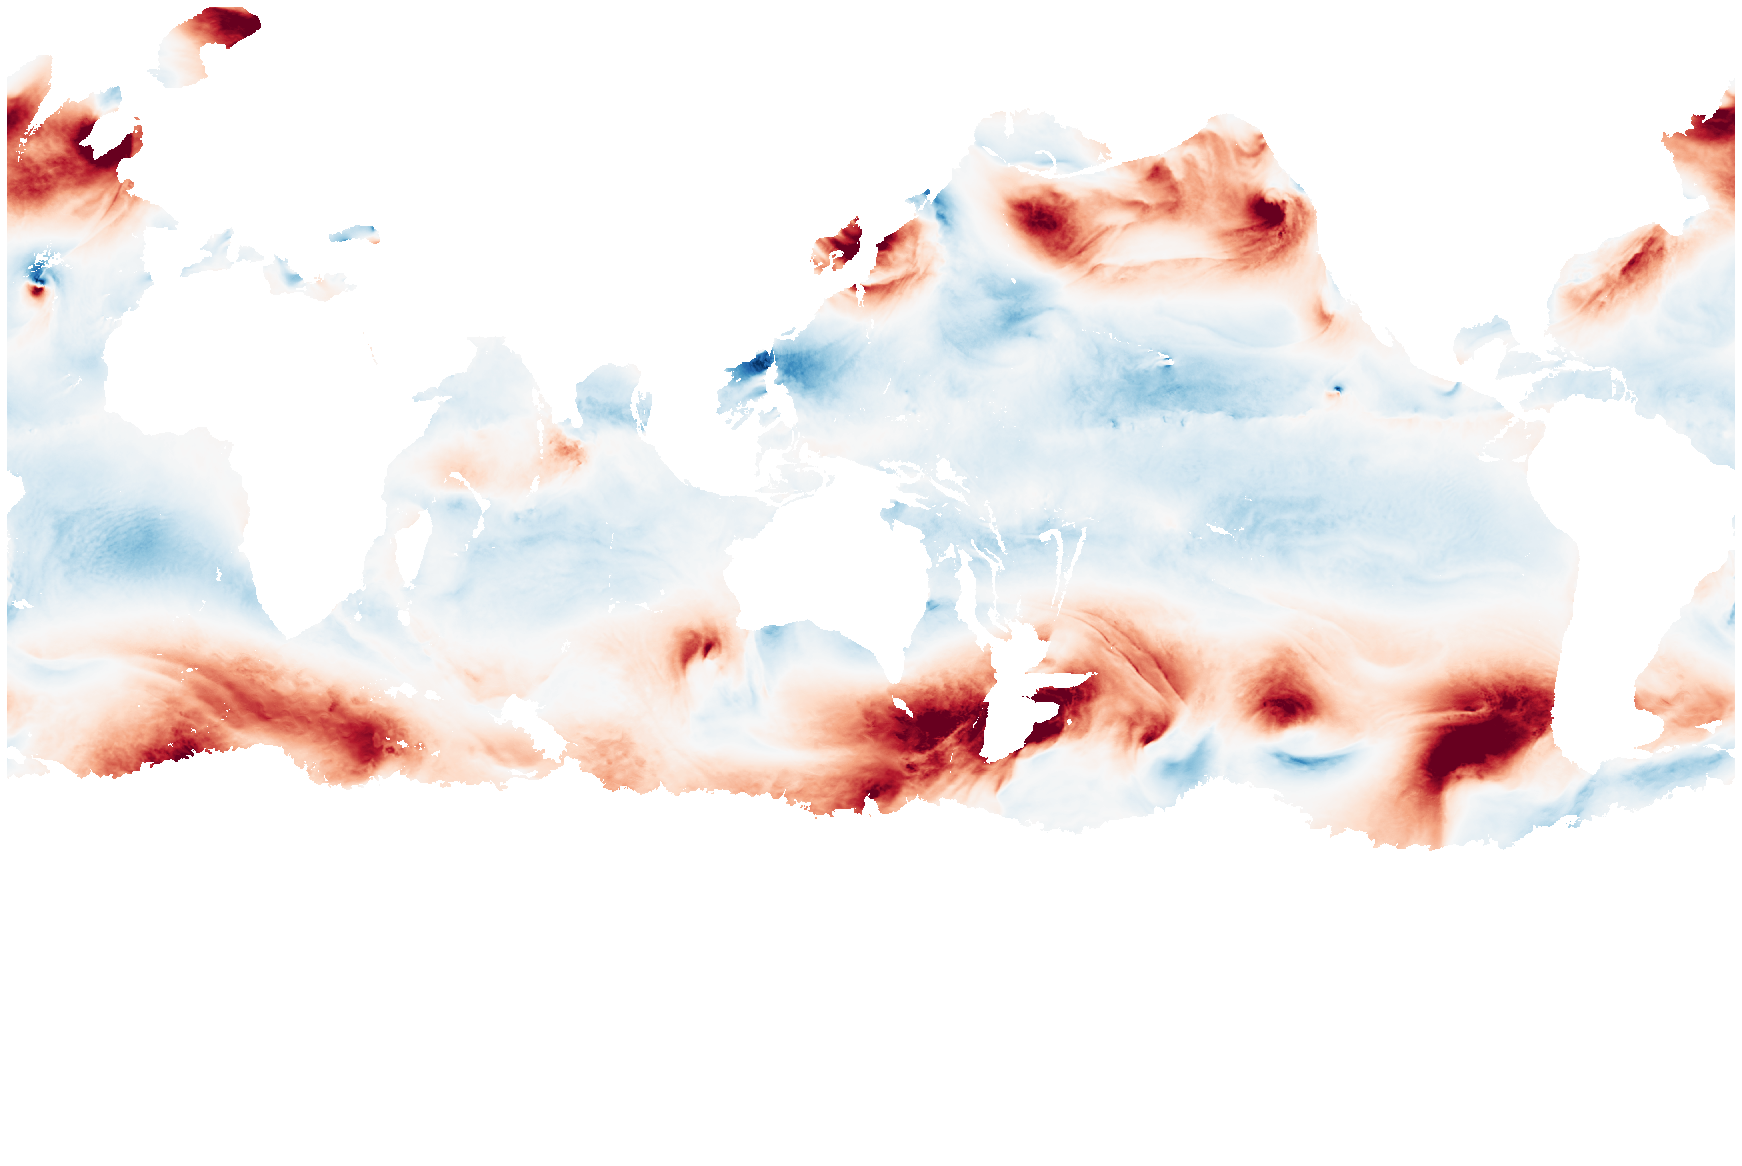

In [30]:
quick_llc_plot(oceTAUX_1.where( (ice.AREA>0)&(ds.Depth>2000) ), vmin=-0.5, vmax=0.5, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

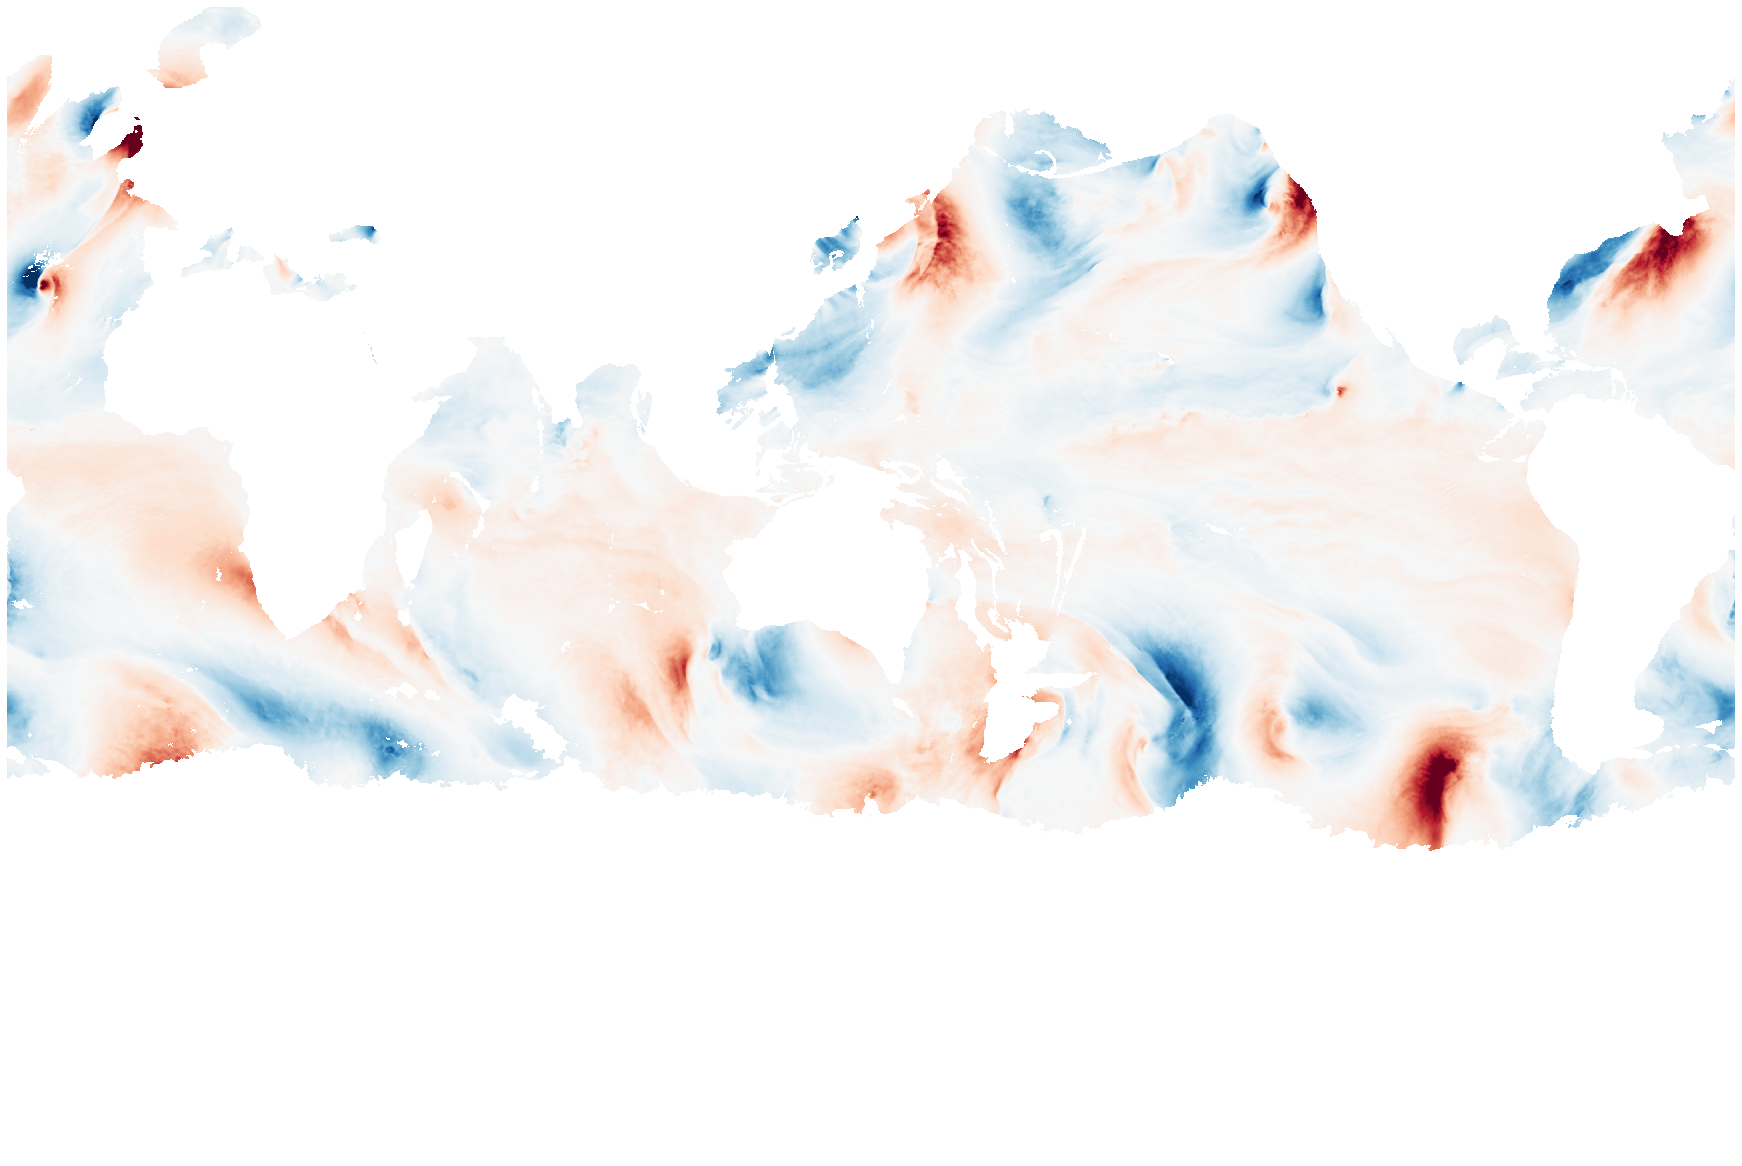

In [31]:
quick_llc_plot(oceTAUY_1.where( (ice.AREA>0)&(ds.Depth>2000) ), vmin=-0.5, vmax=0.5, add_colorbar=False, axis_off=True, cmap = 'RdBu_r')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the

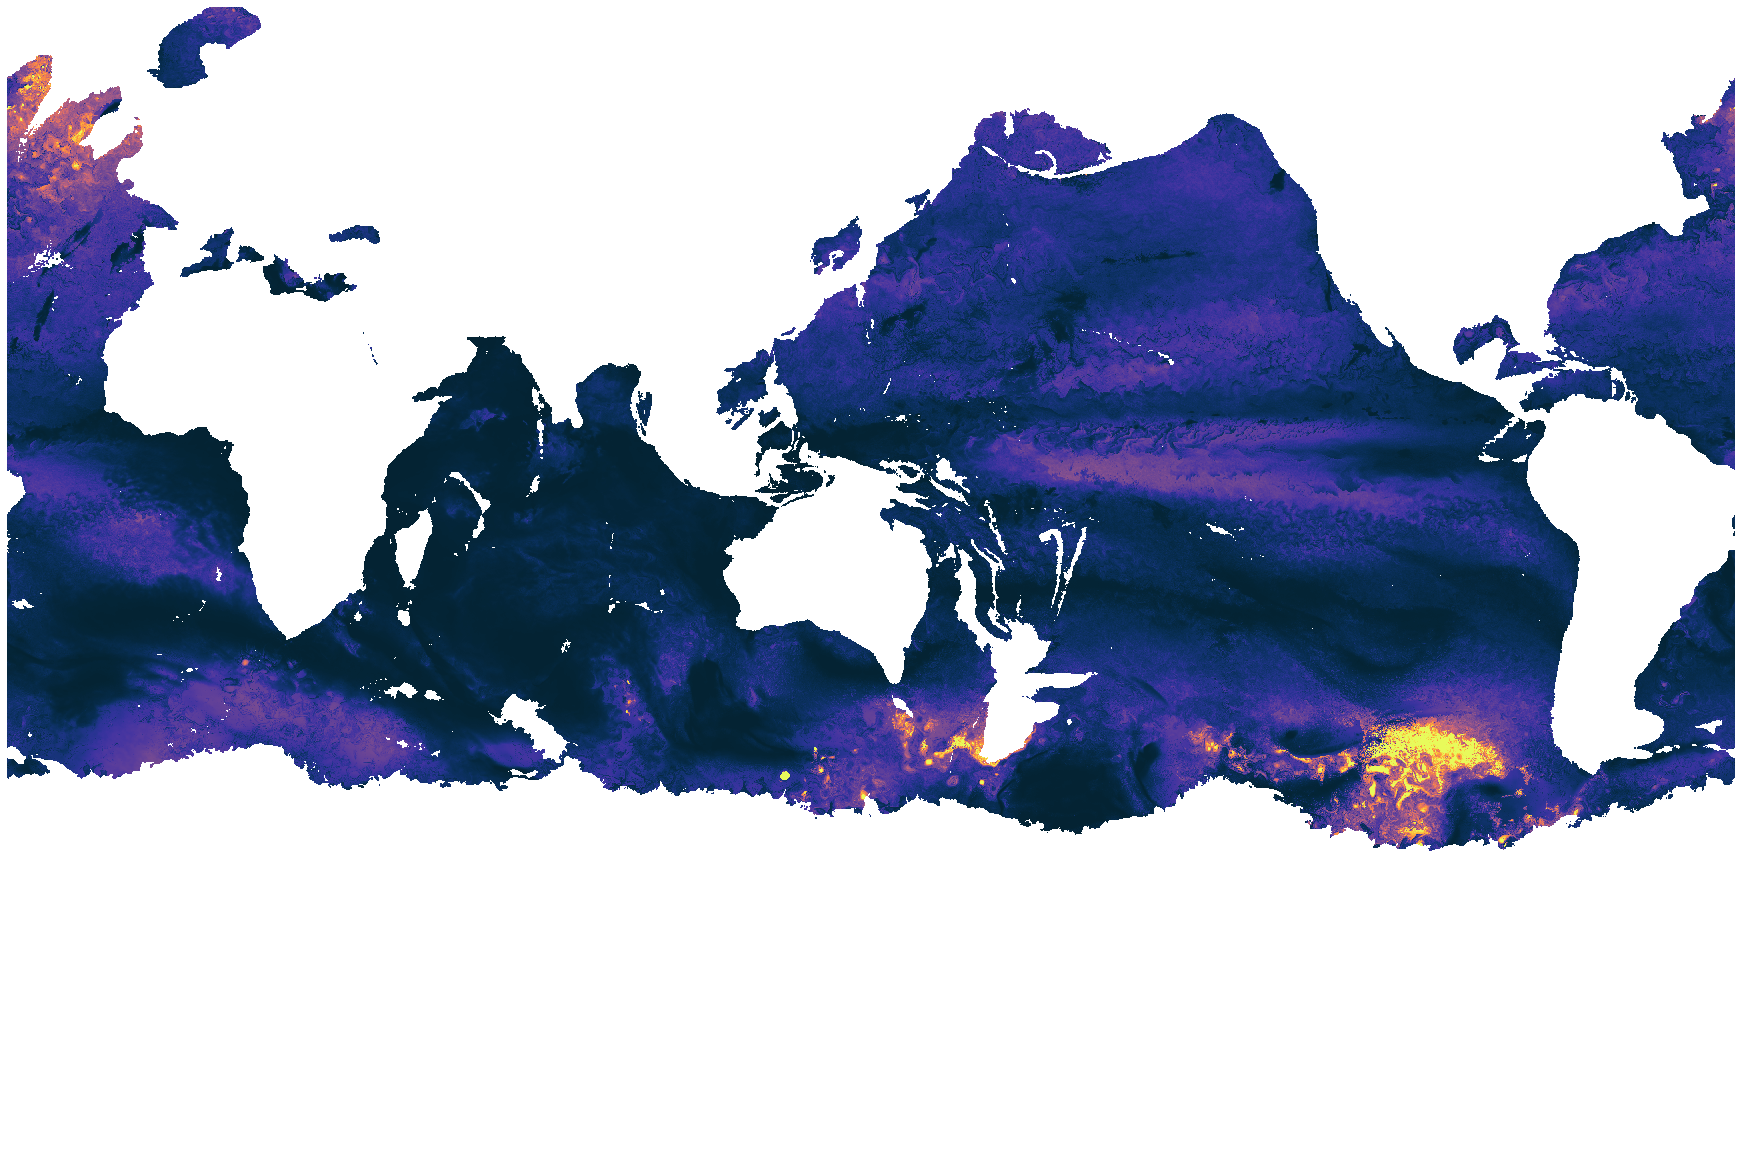

In [32]:
quick_llc_plot(ds.KPPhbl.sel(time='2011-11-24T08:00:00').where( (ice.AREA>0)&(ds.Depth>2000) ), vmin=0, vmax=400, add_colorbar=False, axis_off=True, cmap = cm.thermal)

________________

# 2. compute RMS


In [19]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'

# read rechunked data
grid = xr.open_zarr(out_dir_zarr+'grid.zarr')
ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl.zarr').isel(time=slice(0,None,24))
ds_TAUX = xr.open_zarr(out_dir_zarr+'oceTAUX.zarr').isel(time=slice(0,None,24))
ds_TAUY = xr.open_zarr(out_dir_zarr+'oceTAUY.zarr').isel(time=slice(0,None,24))

# data merge
ds = xr.merge([ds_KPP,ds_TAUX,ds_TAUY,grid])
print(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 358)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(9,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-11-14T08:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   (k) float32 dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (face,

In [25]:
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = store_dir_zarr+'TAU_H_rms_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        oceTAUX_H_rms = ( (ds.oceTAUX.isel(face=face).rename({'i_g': 'i'}).isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ds.KPPhbl.isel(face=face,i=slice(0, None, 4),j=slice(0 ,None, 4))/1025 )**2 ).mean(['time'])     
        oceTAUY_H_rms = ( (ds.oceTAUY.isel(face=face).rename({'j_g': 'j'}).isel(j=slice(0 ,None, 4), i=slice(0, None, 4))/ds.KPPhbl.isel(face=face,i=slice(0, None, 4),j=slice(0 ,None, 4))/1025 )**2 ).mean(['time'])
        oceTAU_H_rms = np.sqrt(oceTAUX_H_rms+oceTAUY_H_rms)
        chunks = {'i': 1080, 'j': 1080}
        oceTAU_H_rms = oceTAU_H_rms.chunk(chunks)
        
        # store
        oceTAU_H_rms = np.real(oceTAU_H_rms).rename('oceTAU_H_rms')
        oceTAU_H_rms = oceTAU_H_rms.to_dataset()
        #print(oceTAU_H_rms)
        
        for c in oceTAU_H_rms.coords:
            try:
                del E[c].encoding['chunks']
            except:
                pass        
        
        %time oceTAU_H_rms.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

CPU times: user 3.99 s, sys: 276 ms, total: 4.26 s
Wall time: 10.4 s
--- face 0 done
CPU times: user 4.45 s, sys: 204 ms, total: 4.65 s
Wall time: 13.2 s
--- face 1 done
CPU times: user 4.16 s, sys: 248 ms, total: 4.4 s
Wall time: 11.4 s
--- face 2 done
CPU times: user 3.99 s, sys: 228 ms, total: 4.22 s
Wall time: 10 s
--- face 3 done
CPU times: user 4.48 s, sys: 252 ms, total: 4.73 s
Wall time: 14.1 s
--- face 4 done
CPU times: user 3.96 s, sys: 192 ms, total: 4.16 s
Wall time: 9.13 s
--- face 5 done
CPU times: user 4.4 s, sys: 232 ms, total: 4.63 s
Wall time: 13.3 s
--- face 6 done
CPU times: user 4.31 s, sys: 304 ms, total: 4.61 s
Wall time: 13.2 s
--- face 7 done
CPU times: user 4.46 s, sys: 268 ms, total: 4.73 s
Wall time: 14.4 s
--- face 8 done
CPU times: user 4.18 s, sys: 268 ms, total: 4.45 s
Wall time: 11.5 s
--- face 9 done
CPU times: user 4.14 s, sys: 300 ms, total: 4.44 s
Wall time: 11.4 s
--- face 10 done
CPU times: user 4.43 s, sys: 228 ms, total: 4.66 s
Wall time: 13.4 s

_________
# 2.1 Read and plot RMS results

In [26]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/TAU/'
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

D = [xr.open_zarr(store_dir_zarr+'TAU_H_rms_f%02d.zarr'%(face)) for face in face_all] 
ds_TAU_H = xr.concat(D, dim='face')
ds_TAU_H 

<xarray.Dataset>
Dimensions:       (face: 13, i: 1080, j: 1080)
Coordinates:
  * i             (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j             (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    CS            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    SN            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC            (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxC           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dxG           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyC           (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    dyG    

In [27]:
out_dir_zarr = '/home/datawork-lops-osi/equinox/mit4320/zarr/'
ice = xr.open_zarr(out_dir_zarr+'sea_ice_mask.zarr').isel(j=slice(0 ,None, 4), i=slice(0, None, 4))
ice

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
Data variables:
    AREA     (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [23]:
font_size = 32

def plot_pretty(v, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                offline=False, figsize=(20,12), cmmap='thermal',
                ignore_face=[]):
    
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
        cmap = getattr(cm, cmmap)
        gen = (face for face in v.face.values if face not in ignore_face)
        for face in gen:
            vplt = v.sel(face=face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>=0) & (vplt.XC<=180.)).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                im = vplt.where(vplt.XC<=0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', add_colorbar=colorbar, cmap=cmap)
                
        cax = plt.axes([0.925, 0.25, 0.025, 0.5])
        cb = plt.colorbar(im, cax=cax, ticks=[0, 1e-5, 2e-5, 3e-5,4e-5])
        cb.ax.set_yticklabels(['0','1','2','3','4'])
        cb.ax.tick_params(labelsize=font_size)
        ax.set_title('',fontsize=font_size)
        ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
        ax.set_xticklabels(['$180\degree$W','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$E'])
        ax.set_ylim(-70., 70.)
        ax.set_yticks([-60, -40, -20, 0, 20, 40, 60])
        ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
        ax.tick_params(direction='out', length=6, width=2)
        ax.set_ylabel('',fontsize=font_size)
        ax.set_xlabel('',fontsize=font_size)
        ax.tick_params(labelsize=font_size)
        if title is not None:
            ax.set_title(title)
        if label is not None:
            cb.set_label(label=label, size=font_size)     #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        if not offline:
            plt.show()
            

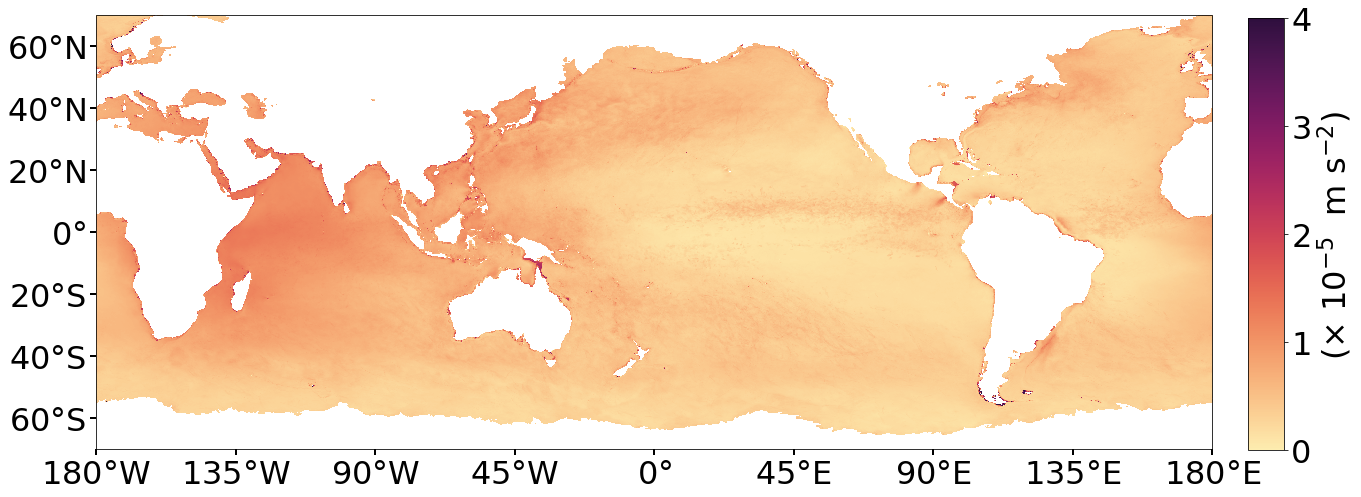

In [24]:
plot_pretty(ds_TAU_H.oceTAU_H_rms.where(ice.AREA>0), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=4e-5, cmmap='matter', ignore_face=[6])

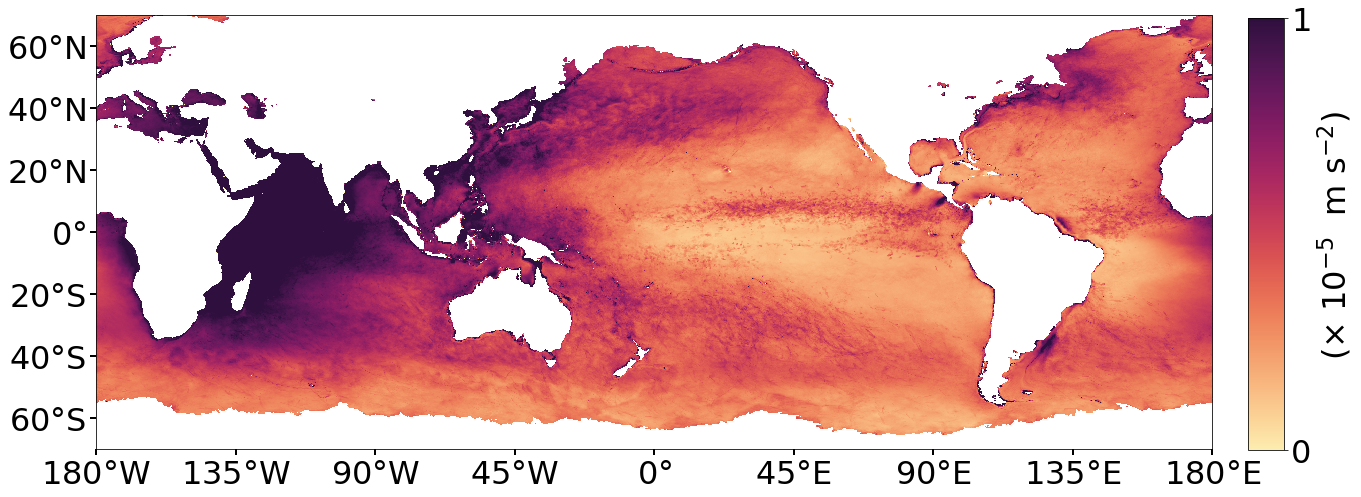

In [28]:
plot_pretty(ds_TAU_H.oceTAU_H_rms.where(ice.AREA>0), label=r'($\times$ 10$^{-5}$  m s$^{-2}$)', vmin=0, vmax=1e-5, cmmap='matter', ignore_face=[6])

In [29]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
